## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = './data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
ratings = pd.read_csv(path+'train_ratings.csv')


print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


### Users

In [3]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [5]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,68092.0,139381.329539,80523.969862,8.0,69008.75,138845.5,209388.25,278854.0
age,40259.0,36.069873,13.842571,5.0,25.00,34.0,45.00,99.0


In [6]:
users['user_id'].nunique()

68092

In [7]:
# users에서 nan값을 가지고 있는 비율 구하기
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

#### preprocessing and feature engineering

In [8]:
# 특수문자 제거 -> , 를 기준으로 country, state, city 쪼개기
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '')

# lambda를 사용하는 이유 - users['location'] dtype = series
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

# age: 특수문자 제거로 n/a가 na로 변경됨, location : ,,,입력된 경우 => 결측값으로 변화
users = users.replace('na', np.nan)
users = users.replace('', np.nan)

users.head(10)

/tmp/ipykernel_12731/2979379579.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '')


,user_id,location,age,location_city,location_state,location_country
0,8,"timmins,ontario,canada",NaN,timmins,ontario,canada
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
2,11676,"na,na,na",NaN,NaN,NaN,NaN
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada
5,96054,"ottawa,ontario,canada",29.0,ottawa,ontario,canada
6,116866,"ottawa,,",NaN,ottawa,NaN,NaN
7,123629,"kingston,ontario,canada",NaN,kingston,ontario,canada
8,177458,"ottawa,ontario,canada",29.0,ottawa,ontario,canada
9,200273,"comber,ontario,canada",NaN,comber,ontario,canada


In [9]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       3254
location_country     2124
dtype: int64

In [10]:
### city는 존재하나 state나 country가 NaN인 경우 채워줄 수 있음

# country X, city O 한 데이터들 나열
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
# print(modify_location)

location_list = []
for location in modify_location:
    try:
        # location(city) O, country O 한 데이터를 찾아, value_counts(데이터, 빈도수)를 통해 가장 많이 나타난 데이터 저장
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

# 저장한 데이터를 다시 쪼개어 각각에 빈 곳을 채워 넣음   
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       1132
location_country      271
dtype: int64

##### 💡 IDEA : city O, state X도 동일하게 처리

In [11]:
# state X, city O 한 데이터들 나열
modify_location = users[(users['location_state'].isna())&(users['location_city'].notnull())]['location_city'].values
# print(modify_location)

location_list = []
for location in modify_location:
    try:
        # location(city) O, state O 한 데이터를 찾아, value_counts(데이터, 빈도수)를 통해 가장 많이 나타난 데이터 저장
        right_location = users[(users['location'].str.contains(location))&(users['location_state'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

# 저장한 데이터를 다시 쪼개어 각각에 빈 곳을 채워 넣음   
for location in location_list:  
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state        606
location_country      266
dtype: int64

In [12]:
users[users['age'].isna()]['location_country'].value_counts()

usa              20108
canada            3131
germany           1107
unitedkingdom     1037
australia          484
                 ...  
kenya                1
unitedstaes          1
missouri             1
unknown              1
macedonia            1
Name: location_country, Length: 172, dtype: int64

#### visualization

##### 나이

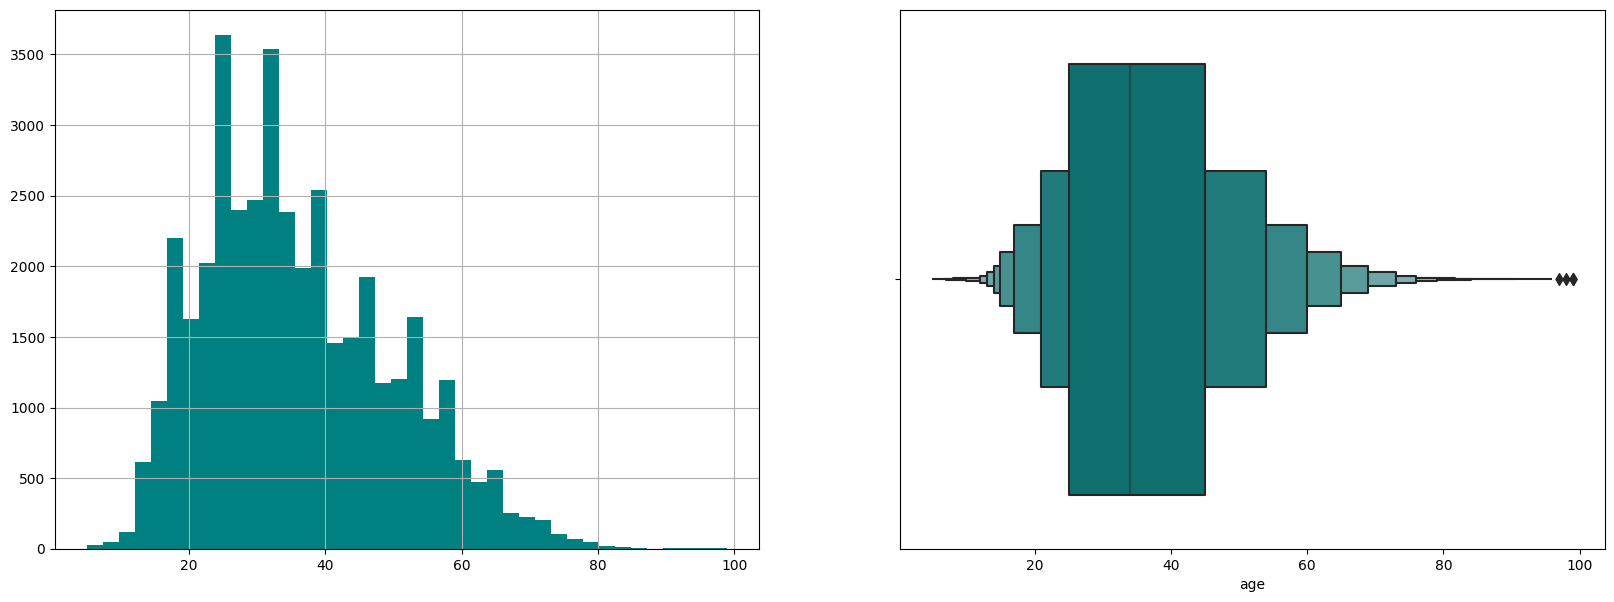

In [13]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

In [14]:
users['age'].value_counts()

29.0    1290
26.0    1250
25.0    1243
34.0    1215
27.0    1207
        ... 
86.0       1
94.0       1
89.0       1
98.0       1
92.0       1
Name: age, Length: 91, dtype: int64

In [15]:
users['age'].nunique()

91

##### 거주지

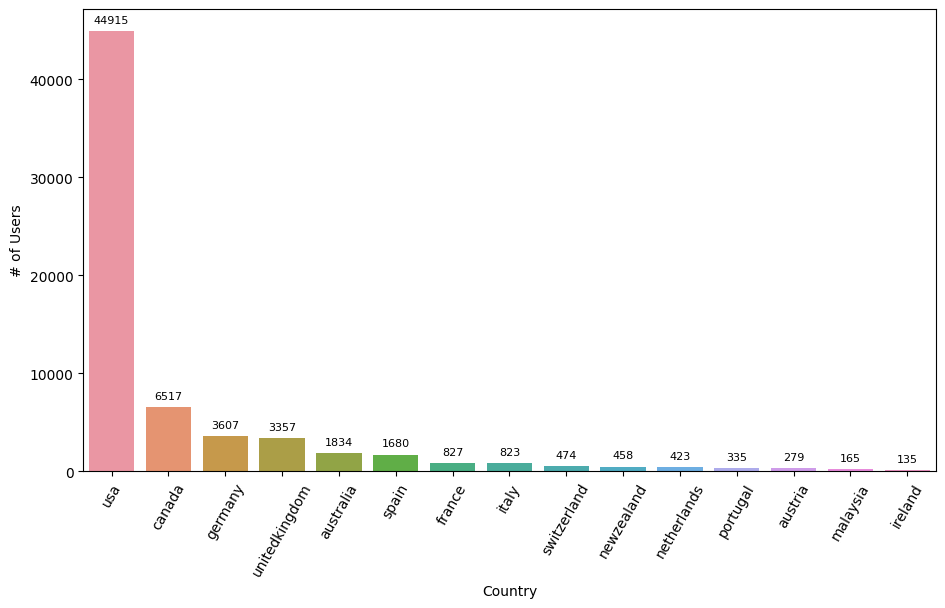

In [16]:
my_dict=(users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

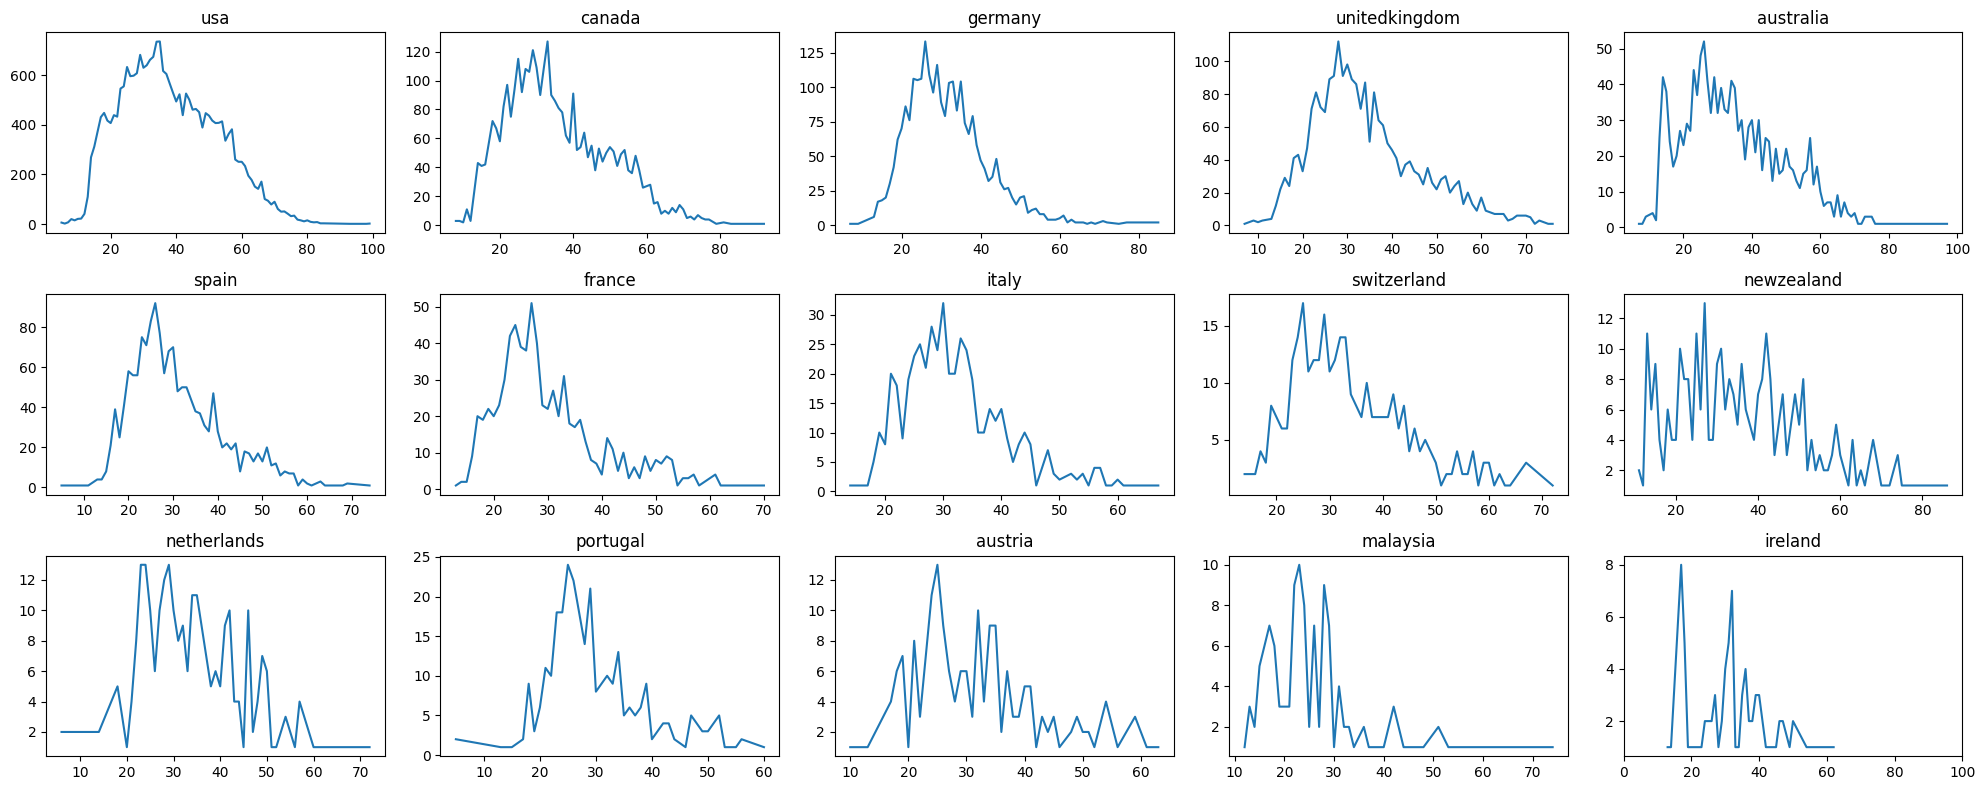

In [17]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

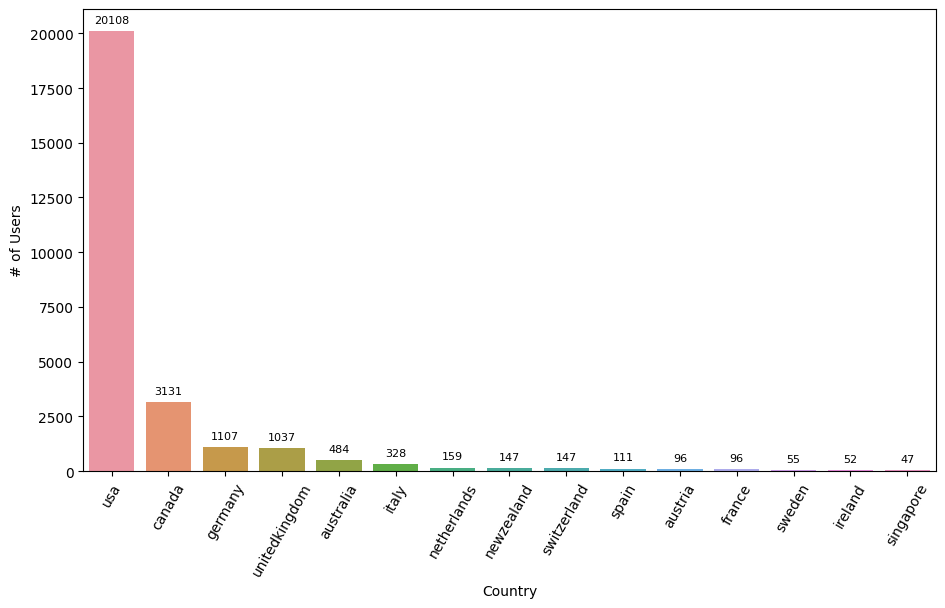

In [18]:
my_dict=(users[users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

### Books

In [19]:
books.shape

(149570, 10)

In [20]:
books['isbn'].nunique()

149570

In [21]:
books['book_title'].nunique()

135436

In [22]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [23]:
books.isna().sum()
# language, category, summary 결측치 존재

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [24]:
books[books['language'].isna() & books['summary'].notnull()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [25]:
books[books['language'].notnull() & books['summary'].isna()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [26]:
books[books['language'].isna() & books['category'].notnull()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [27]:
books[books['language'].notnull() & books['category'].isna()] 

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
138,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,1994.0,Gallimard-Jeunesse,http://images.amazon.com/images/P/2070567842.0...,fr,NaN,Un petit garçon se pose énormément de question...,images/2070567842.01.THUMBZZZ.jpg
193,3596292646,Das Buch der lÃ?Â¤cherlichen Liebe.,Milan Kundera,2000.0,"Fischer (Tb.), Frankfurt",http://images.amazon.com/images/P/3596292646.0...,de,NaN,Die im &#39;Buch der lächerlichen Liebe&#39; v...,images/3596292646.01.THUMBZZZ.jpg
486,0871131811,Zodiac: The Eco-Thriller,Neal Stephenson,1988.0,Pub Group West,http://images.amazon.com/images/P/0871131811.0...,en,NaN,"Sangamon Taylor, an environmental extremist, s...",images/0871131811.01.THUMBZZZ.jpg
880,067144378X,SABLE MOON,Nancy Springer,1981.0,Pocket,http://images.amazon.com/images/P/067144378X.0...,en,NaN,Seventeen-year-old Prince Trevyn must save the...,images/067144378X.01.THUMBZZZ.jpg
1001,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986.0,Del Rey,http://images.amazon.com/images/P/0345339711.0...,en,NaN,"Thus continues the magnificent, bestselling ta...",images/0345339711.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149252,3770401697,"Lucky Luke, Bd.58, Die Geister-Ranch und ander...",Michel Janvier,1989.0,"Egmont Ehapa, Berlin",http://images.amazon.com/images/P/3770401697.0...,de,NaN,"Enth. noch: Die Hellseherin, Die Statue und Di...",images/3770401697.01.THUMBZZZ.jpg
149307,0806917695,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing,http://images.amazon.com/images/P/0806917695.0...,en,NaN,"Normal situations veer off into the bizarre, c...",images/0806917695.01.THUMBZZZ.jpg
149329,3426192543,Im FrÃ?Â¼hling singt zum letztenmal die Lerche.,Johannes Mario Simmel,1990.0,Droemer Knaur,http://images.amazon.com/images/P/3426192543.0...,de,NaN,Eine Gruppe von Idealisten nimmt den Kampf geg...,images/3426192543.01.THUMBZZZ.jpg
149441,2253054615,Le maharani,Gita Mehta,1990.0,LGF,http://images.amazon.com/images/P/2253054615.0...,fr,NaN,Elevée à la cour comme toutes les maharani l&#...,images/2253054615.01.THUMBZZZ.jpg


정리
- langauge & summary : language가 존재하면 summary도 존재한다.
- language & category
    - langauge가 존재하지 않을 때, category가 존재하는 경우는 없다.
    - language가 존재할 때 category는 존재하지 않을 수 있다. 

#### preprocessing & feature engineering

##### isbn : 책의 개별적인 고유번호, 출판국가, 출판사 번호, 항목 번호, 확인숫자

In [28]:
books[['isbn', 'img_url', 'img_path']]

,isbn,img_url,img_path
0,0002005018,http://images.amazon.com/images/P/0002005018.0...,images/0002005018.01.THUMBZZZ.jpg
1,0060973129,http://images.amazon.com/images/P/0060973129.0...,images/0060973129.01.THUMBZZZ.jpg
2,0374157065,http://images.amazon.com/images/P/0374157065.0...,images/0374157065.01.THUMBZZZ.jpg
3,0399135782,http://images.amazon.com/images/P/0399135782.0...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,http://images.amazon.com/images/P/0425176428.0...,images/0425176428.01.THUMBZZZ.jpg
...,...,...,...
149565,067161746X,http://images.amazon.com/images/P/067161746X.0...,images/067161746X.01.THUMBZZZ.jpg
149566,0767907566,http://images.amazon.com/images/P/0767907566.0...,images/0767907566.01.THUMBZZZ.jpg
149567,0884159221,http://images.amazon.com/images/P/0884159221.0...,images/0884159221.01.THUMBZZZ.jpg
149568,0912333022,http://images.amazon.com/images/P/0912333022.0...,images/0912333022.01.THUMBZZZ.jpg


In [29]:
books[books['isbn'] != books['img_url'].apply(lambda x: x.split('P/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [30]:
books[books['isbn']!=books['img_path'].apply(lambda x: x.split('images/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


##### publisher : isbn을 통해 출판사 그룹화

In [31]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)
publisher_count_df.head(10)

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938
5,Berkley Publishing Group,1754
6,Silhouette,1684
7,Warner Books,1667
8,Scholastic,1586
9,Simon & Schuster,1578


In [32]:
books['publisher'].nunique() # 수정전 항목 수를 확인합니다.

11571

In [33]:
books[books['publisher']=="Harlequin"].head(5)              # 0373...
books[books['publisher']=="Penguin Books"].head(5)          # 0140...
books[books['publisher']=="Silhouette"].head(5)             # 0373...
books[books['publisher']=="Simon & Schuster"].head(5)       # 0684...

# 앞 네자리로 publisher 묶기

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
474,0684833395,Catch 22,Joseph Heller,1996.0,Simon & Schuster,http://images.amazon.com/images/P/0684833395.0...,NaN,NaN,NaN,images/0684833395.01.THUMBZZZ.jpg
681,0684854953,Santa Pete : A Novel Of Christmas Present And ...,Christopher Moore,1998.0,Simon & Schuster,http://images.amazon.com/images/P/0684854953.0...,en,['Fiction'],A bus driver takes his grandson along on Satur...,images/0684854953.01.THUMBZZZ.jpg
682,0743229878,Mount Vernon Love Story : A Novel of George an...,Mary Higgins Clark,2002.0,Simon & Schuster,http://images.amazon.com/images/P/0743229878.0...,NaN,NaN,NaN,images/0743229878.01.THUMBZZZ.jpg
892,0743206053,Kitchen Privileges : A Memoir,Mary Higgins Clark,2002.0,Simon & Schuster,http://images.amazon.com/images/P/0743206053.0...,NaN,NaN,NaN,images/0743206053.01.THUMBZZZ.jpg
1042,0684864320,LAKE NEWS : A Novel,Barbara Delinsky,1999.0,Simon & Schuster,http://images.amazon.com/images/P/0684864320.0...,en,['Fiction'],"Lily Blake, forced home to small-town Lake Hen...",images/0684864320.01.THUMBZZZ.jpg


In [34]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
modify_list

array(['Harlequin', 'Ballantine Books', 'Pocket', ..., 'Guild Publishing',
       'Andre Deutsch', 'Peppermind'], dtype=object)

In [35]:
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [36]:
books['publisher'].nunique() #수정 후 출판사 갯수입니다 (수정 전 : 11571)

1523

##### category : 상위 카테고리 추출 후 그룹화

In [37]:
import re

# category에서 대괄호를 뺌
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub("[^a-zA-Z\s]", "", x).strip())

# 소문자로 변경
books['category'] = books['category'].str.lower()

books['category'].value_counts()

fiction                                          33016
juvenile fiction                                  5835
biography  autobiography                          3326
history                                           1927
religion                                          1818
                                                 ...  
emotional intelligence                               1
critical theory                                      1
wrocaw poland                                        1
mormon church                                        1
authors canadian english th century biography        1
Name: category, Length: 4101, dtype: int64

In [38]:
books['category'].isna().sum()

68851

In [39]:
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']
category_df

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818
...,...,...
4096,emotional intelligence,1
4097,critical theory,1
4098,wrocaw poland,1
4099,mormon church,1


In [40]:
### 이 부분을 groupby로 수정할 수 있지 않을까
major_list = category_df[category_df['count']>=5]['category'].values

# major list
# 개수가 5개 이상인 것들 중 대분류하기 위해 자주 나오는 카테고리 단어 추출
dict = []
for c in major_list:
    wrds = c.split()
    dict += wrds

# dict = list(set(dict))
dict_count = {d: 0 for d in dict}
for wrd in dict:
    dict_count[wrd] += 1

# 카테고리 단어들 중 자주 나타나는 
categories = []
for k in dict_count.keys():
    if dict_count[k] >= 3:
        if k in ['in', 'and', 'or']:
            continue
        categories.append(k)
print(categories)  


['fiction', 'biography', 'history', 'social', 'science', 'humor', 'business', 'economics', 'family', 'psychology', 'poetry', 'drama', 'language', 'crime', 'music', 'detective', 'mystery', 'stories', 'childrens', 'animals', 'adventure', 'games', 'american', 'english', 'christian', 'life', 'bible', 'england', 'fantasy', 'tales', 'authors', 'german', 'african', 'children', 'horror', 'wit', 'french', 'literature', 'christmas', 'books', 'motion', 'child', 'schools', 'behavior', 'computer', 'fictitious', 'character', 'personal', 'readers', 'spanish', 'college']


In [80]:
category_dict =(books['category'].value_counts()).to_dict()
category_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['category','count'])
category_count_df.sort_values(by=['count'], ascending = False).head(30)

,category,count
0,Pocket,7306
1,Harlequin,5268
2,Bantam Books,4815
3,St. Martin's Press,4043
4,Vintage Books USA,3822
5,Penguin Books,3807
6,Perennial,3313
7,Ballantine Books,3090
8,Signet Book,3068
9,Avon,2792


In [41]:
books['category_high'] = books['category'].copy()

In [42]:
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

books['category_high']

0         actresses
1                  
2           medical
3           fiction
4           history
            ...    
149565        humor
149566       nature
149567          NaN
149568      fiction
149569          NaN
Name: category_high, Length: 149570, dtype: object

In [43]:
others_list = category_df[category_df['count']<5]['category'].values
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

books['category_high']

0         actresses
1                  
2           medical
3           fiction
4           history
            ...    
149565        humor
149566       nature
149567          NaN
149568      fiction
149569          NaN
Name: category_high, Length: 149570, dtype: object

In [44]:
books['category'].nunique()

4101

In [45]:
# 기존 4292
books['category_high'].nunique()

351

In [46]:
books['category'] = books['category_high'].copy()
books = books.drop(columns='category_high')

In [47]:
books['category'].nunique()

351

##### book title

#### visualization

- image url 활용

In [48]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

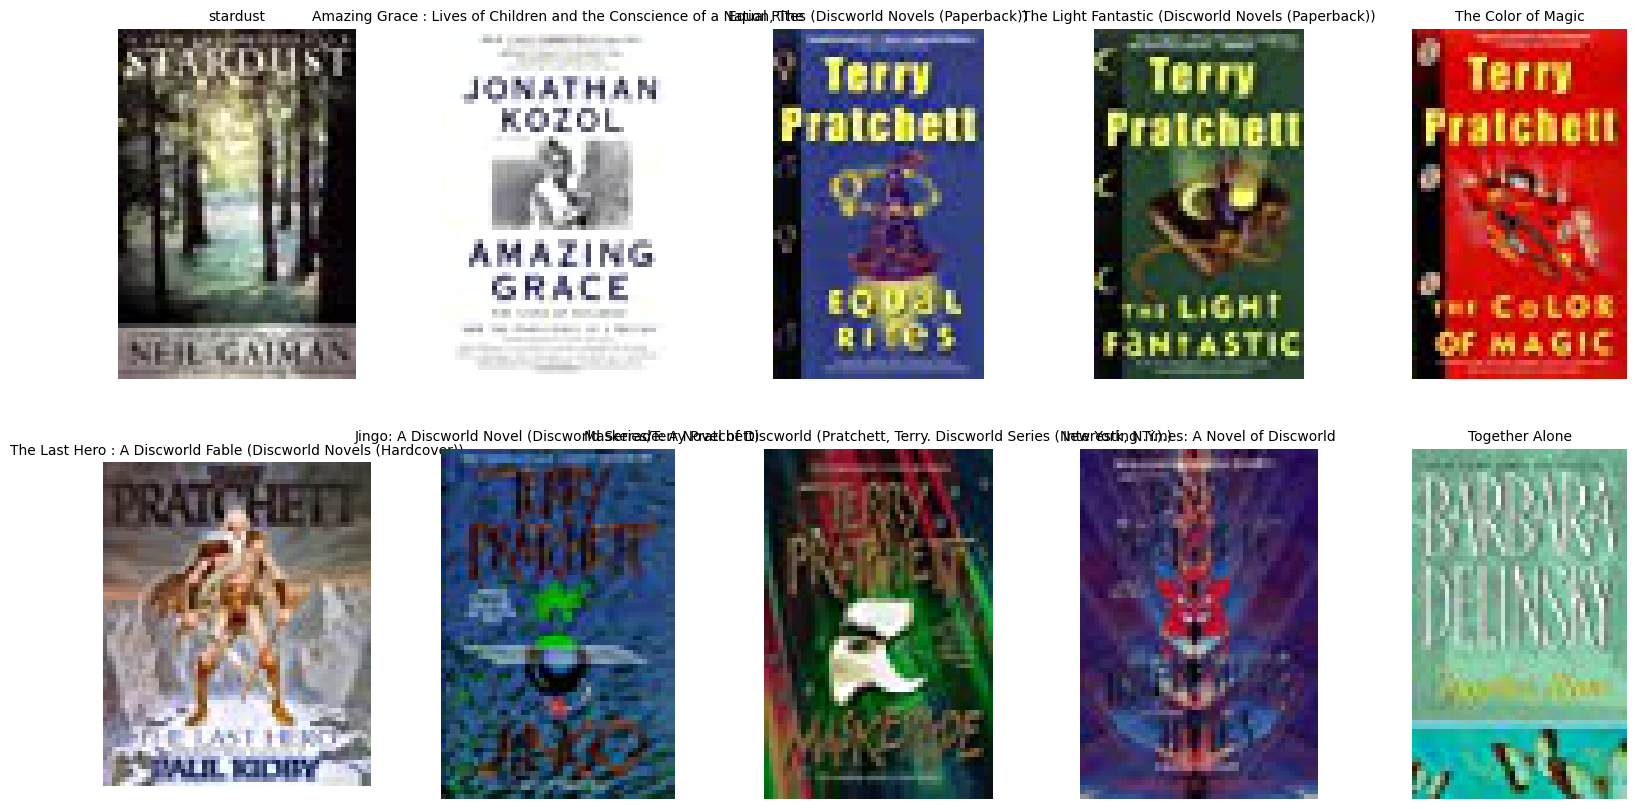

In [49]:
books[books['book_title'].str.contains('Harry')].head()

parameters = {
          'axes.titlesize': 10}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(2, 5, figsize=(20, 10)) 

for i, ax in zip(range(282, 292), ax.flatten()):
    url = books['img_url'][i]
    img = np.asarray(Image.open(requests.get(url, stream=True).raw))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()

- image path 활용

In [50]:
import os

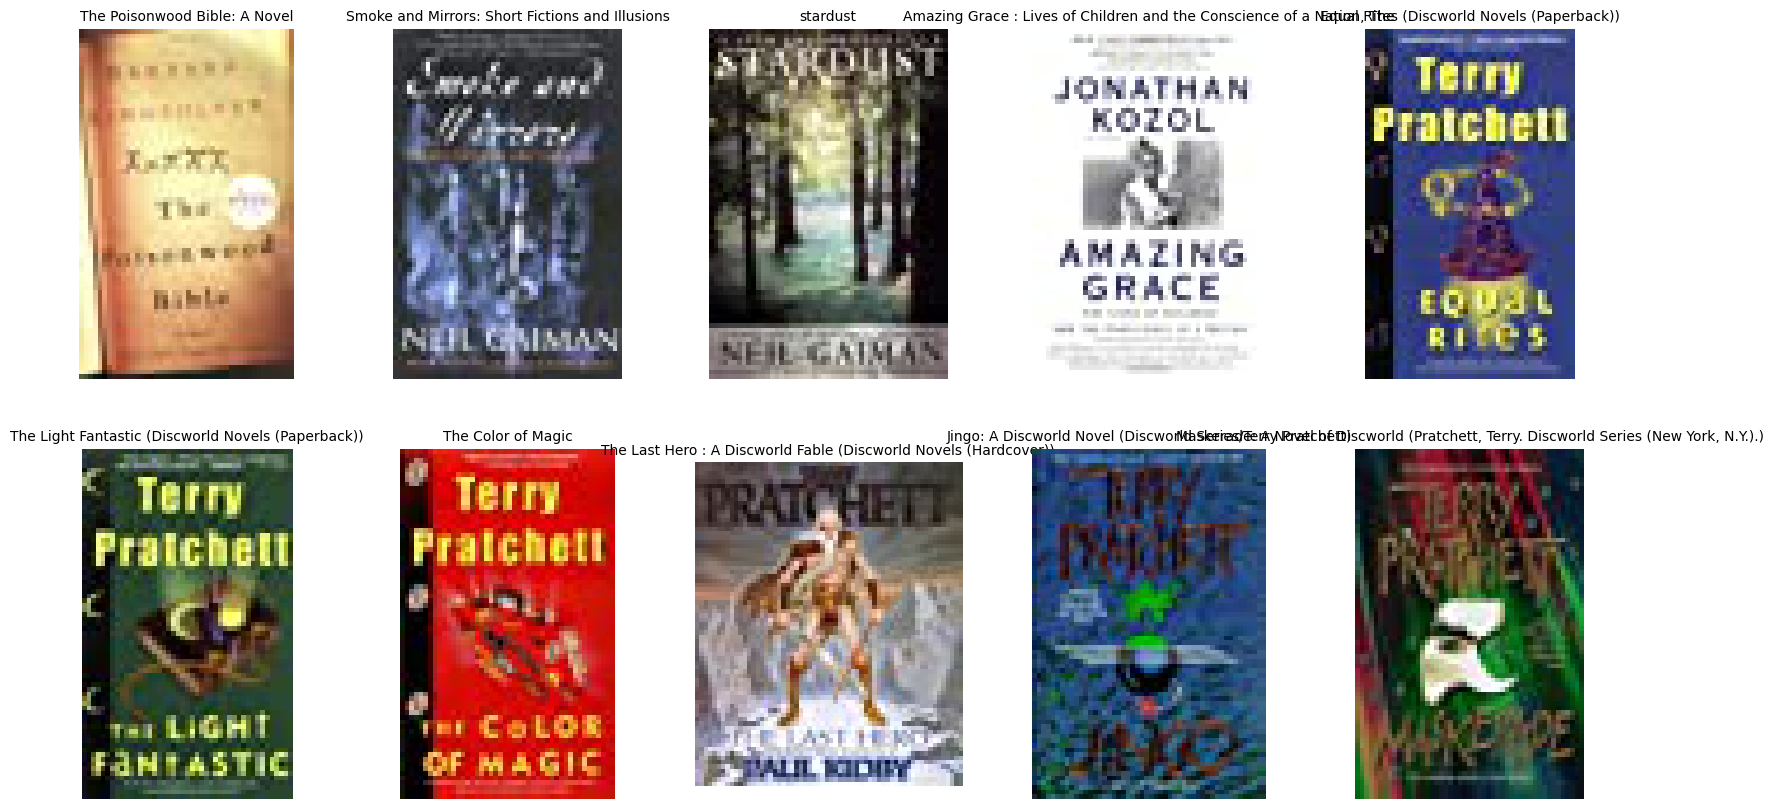

In [51]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10)) 
image_path = '/opt/ml/input/code/data/'
for i, ax in zip(range(280, 290), ax.flatten()):
    file_path = image_path+books['img_path'][i]
    img = np.asarray(Image.open(file_path))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()

- 이외의 정보 시각화

In [52]:
books['publisher'].value_counts().head(10)

Pocket                7306
Harlequin             5268
Bantam Books          4815
St. Martin's Press    4043
Vintage Books USA     3822
Penguin Books         3807
Perennial             3313
Ballantine Books      3090
Signet Book           3068
Avon                  2792
Name: publisher, dtype: int64

/tmp/ipykernel_12731/3162667516.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')


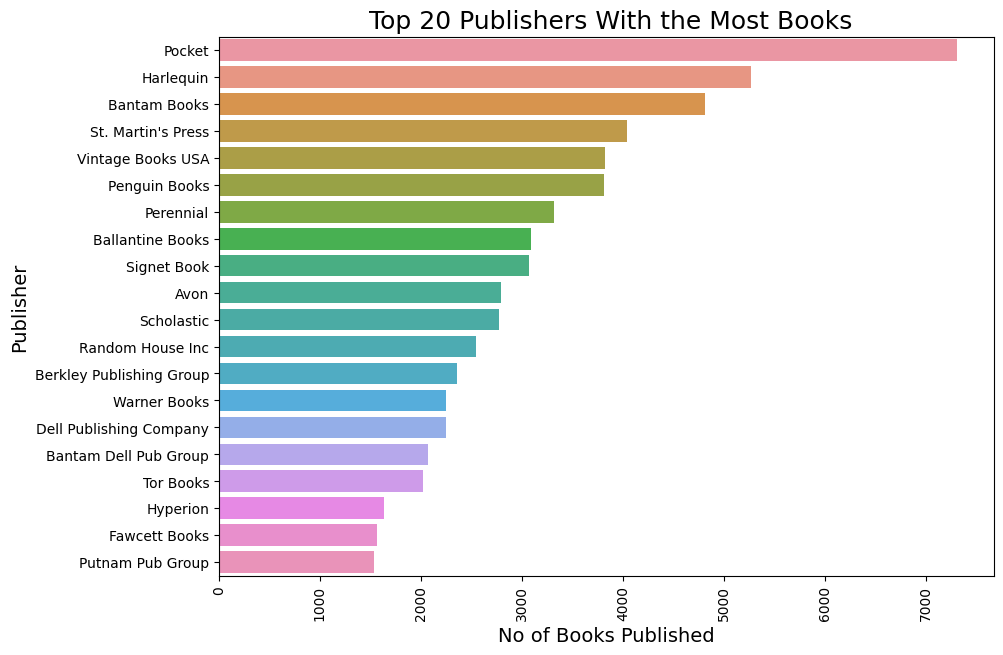

In [53]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

b = publisher_count_df.sort_values(by=['count'], ascending = False)
b = b.head(20)

fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'publisher' , data = b)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
plt.xlabel("No of Books Published", size=14)
plt.ylabel("Publisher", size=14)
plt.title(" Top 20 Publishers With the Most Books", size=18)

plt.show()

In [54]:
print(sorted(books['year_of_publication'].unique()),end=' ') 

[1376.0, 1378.0, 1806.0, 1900.0, 1901.0, 1902.0, 1904.0, 1906.0, 1908.0, 1911.0, 1920.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0] 

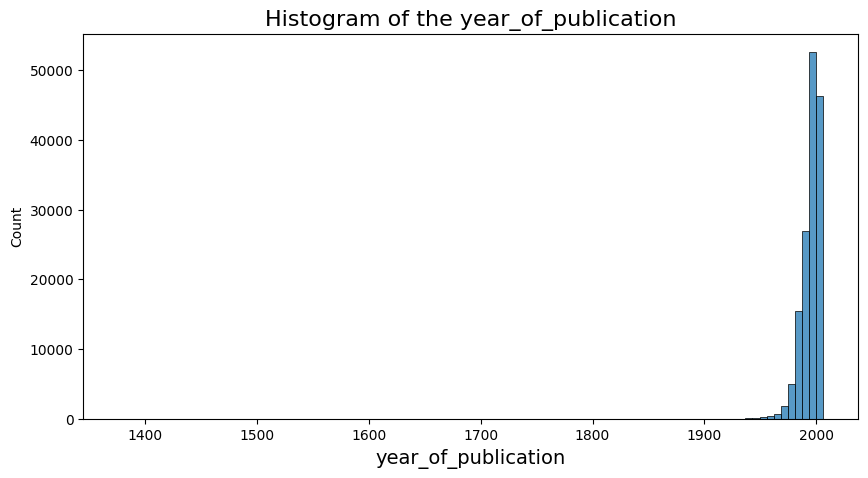

In [55]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

In [56]:
books['year_of_publication'].value_counts().sort_index()

1376.0        1
1378.0        1
1806.0        1
1900.0        1
1901.0        4
          ...  
2002.0    11669
2003.0     9430
2004.0     3771
2005.0       19
2006.0        1
Name: year_of_publication, Length: 95, dtype: int64

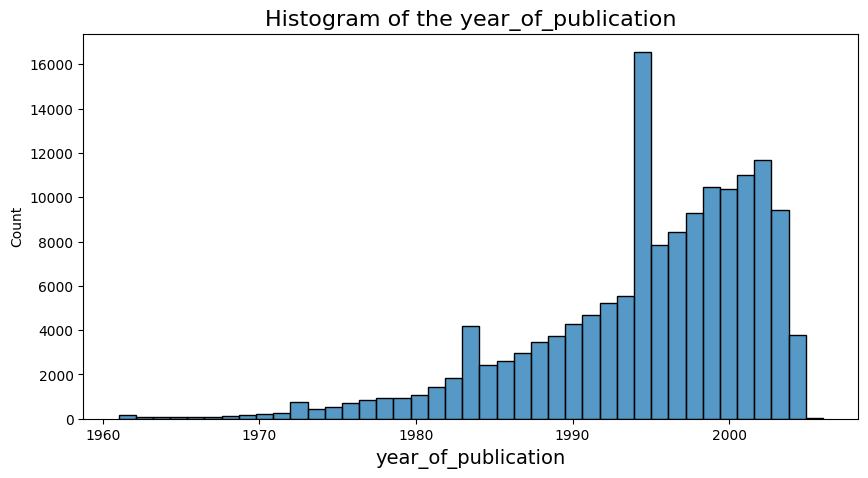

In [57]:
plt.figure(figsize=(10,5))
sns.histplot(books[books['year_of_publication']>1960]['year_of_publication'],bins=41)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

### Ratings

In [58]:
ratings.head()

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9


In [59]:
ratings['user_id'].nunique()

59803

In [60]:
ratings.shape

(306795, 3)

In [61]:
ratings['rating'].value_counts(True)

8     0.239877
7     0.172519
9     0.158650
10    0.139422
6     0.082501
5     0.045995
1     0.043185
2     0.042142
4     0.041419
3     0.034290
Name: rating, dtype: float64

#### preprocessing & engineering

#### visiualization

- heavy user : 책을 많이 읽은 유저들

In [62]:
#유저당 몇 권 정도의 책을 읽었는지 살펴보겠습니다.
ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20)

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
235105     812
76499      810
171118     771
16795      760
248718     747
56399      673
197659     637
35859      614
185233     557
95359      488
114368     483
101851     452
158295     444
177458     417
182085     409
Name: rating, dtype: int64

In [63]:
heavy_users_list = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20).index
heavy_users_list

Int64Index([ 11676,  98391, 189835, 153662,  23902, 235105,  76499, 171118,
             16795, 248718,  56399, 197659,  35859, 185233,  95359, 114368,
            101851, 158295, 177458, 182085],
           dtype='int64', name='user_id')

In [64]:
ratings[ratings['user_id'].isin(heavy_users_list)].groupby('user_id')['rating'].mean()

user_id
11676     6.779891
16795     6.423684
23902     7.174686
35859     7.175896
56399     9.312036
76499     8.477778
95359     7.200820
98391     8.566228
101851    8.420354
114368    4.364389
153662    8.209893
158295    5.770270
171118    6.961089
177458    6.757794
182085    8.210269
185233    3.263914
189835    3.184298
197659    8.116170
235105    7.713054
248718    7.419009
Name: rating, dtype: float64

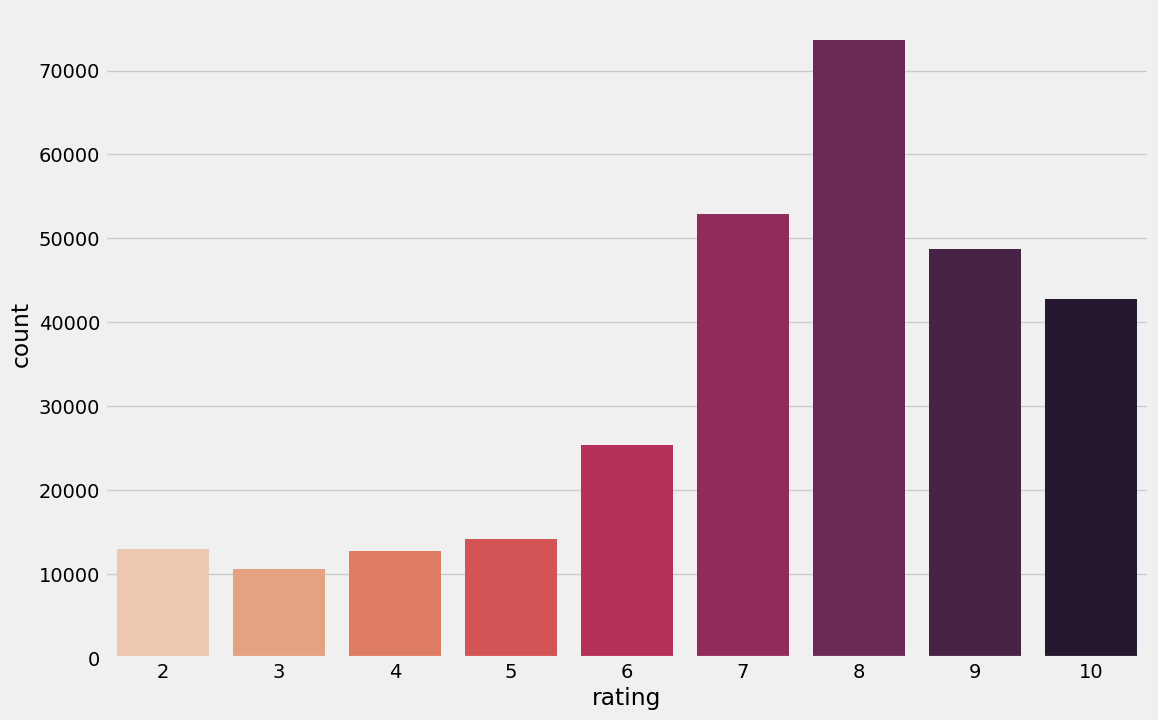

In [65]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

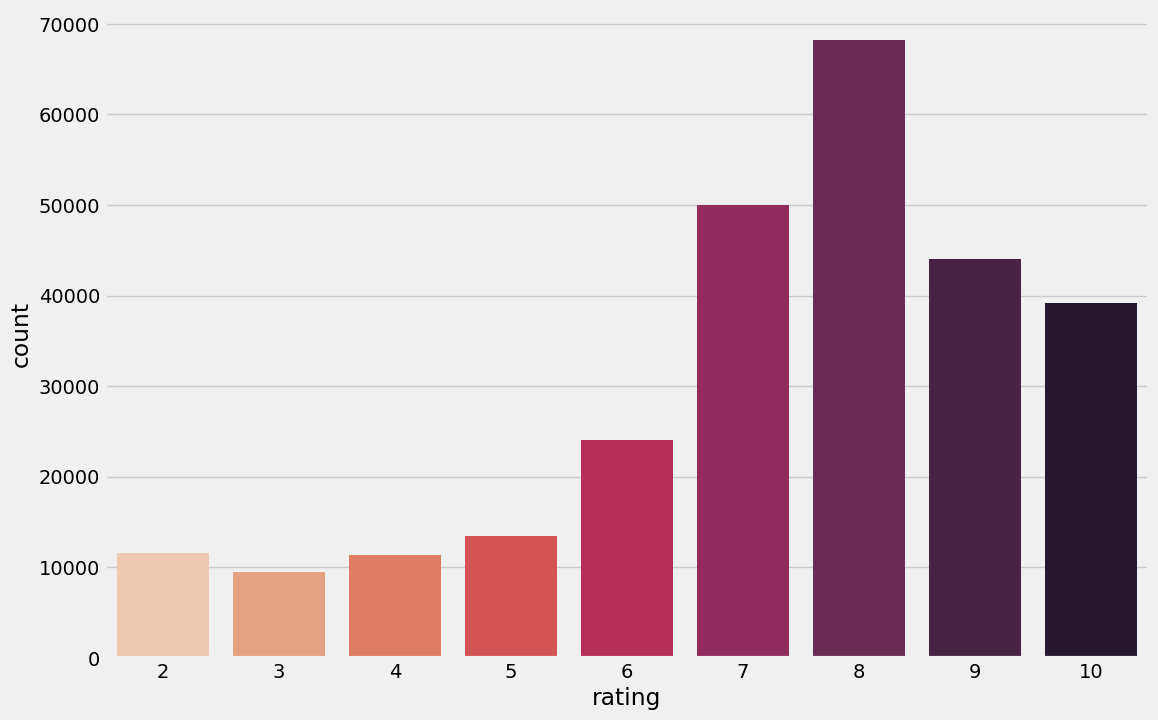

In [66]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[~(ratings['user_id'].isin(heavy_users_list))&(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

##### books

In [67]:
ratings.groupby('isbn')['rating'].count().sort_values(ascending=False)

isbn
0316666343    566
0971880107    465
0385504209    390
0312195516    307
0060928336    256
             ... 
0520060199      1
0520059808      1
0520058852      1
0520058763      1
B000234N3A      1
Name: rating, Length: 129777, dtype: int64

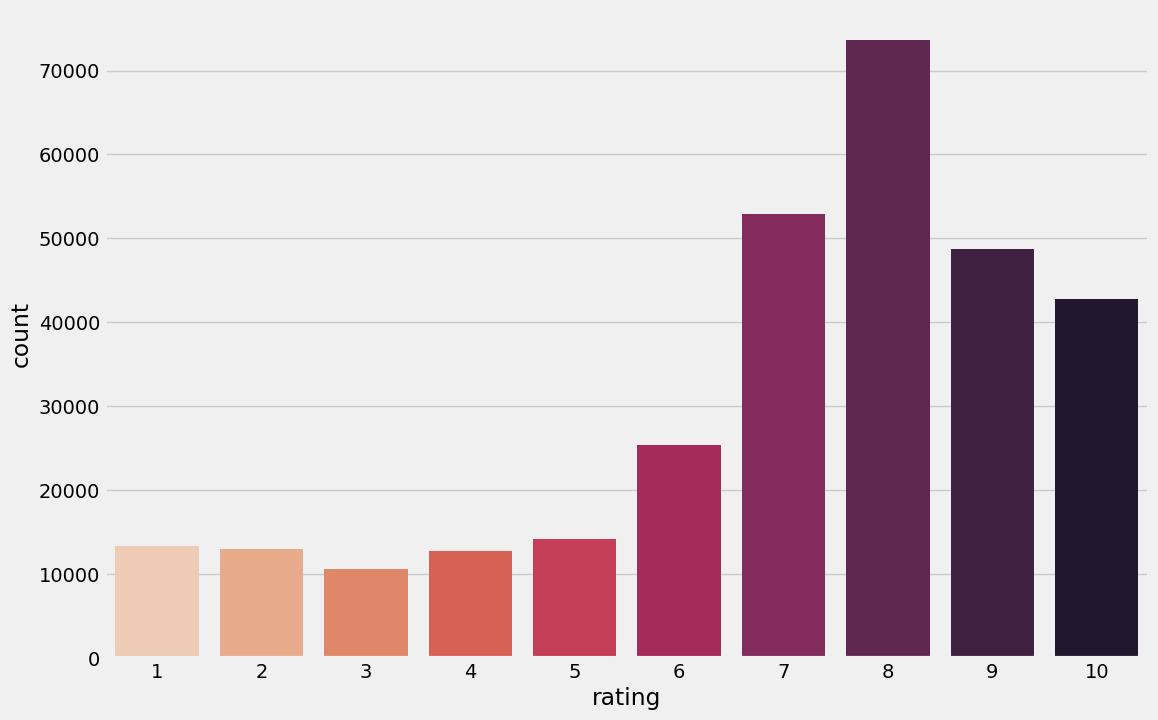

In [68]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings , x='rating', palette='rocket_r')
plt.show()

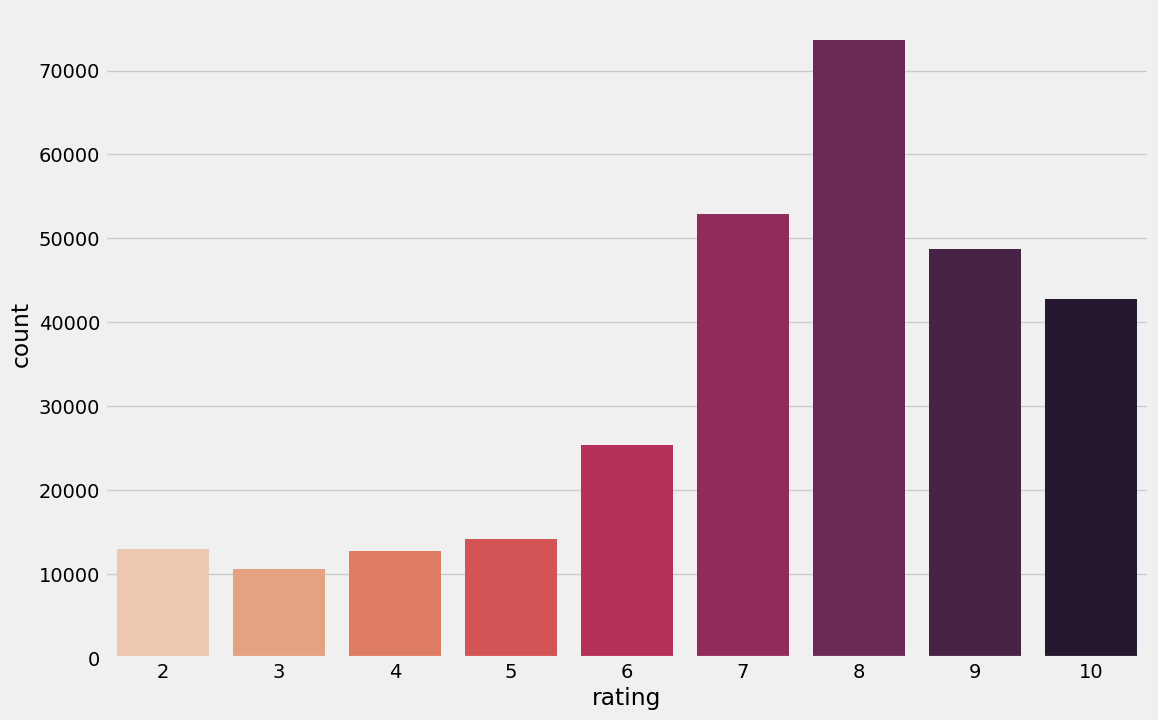

In [69]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[(ratings['rating']>1)] , x='rating', palette='rocket_r')
plt.show()

### 3파일 간 관계

In [70]:
merge1 = ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 17)


In [71]:
ratings.shape

(306795, 3)

In [72]:
# books에 있는 내용이 ratings에 모두 잘 합쳐졌는지 확인하기 위함
set(ratings['isbn']) - set(books['isbn']) 

set()

#### visualization

- book_title을 통해 popular book 추출

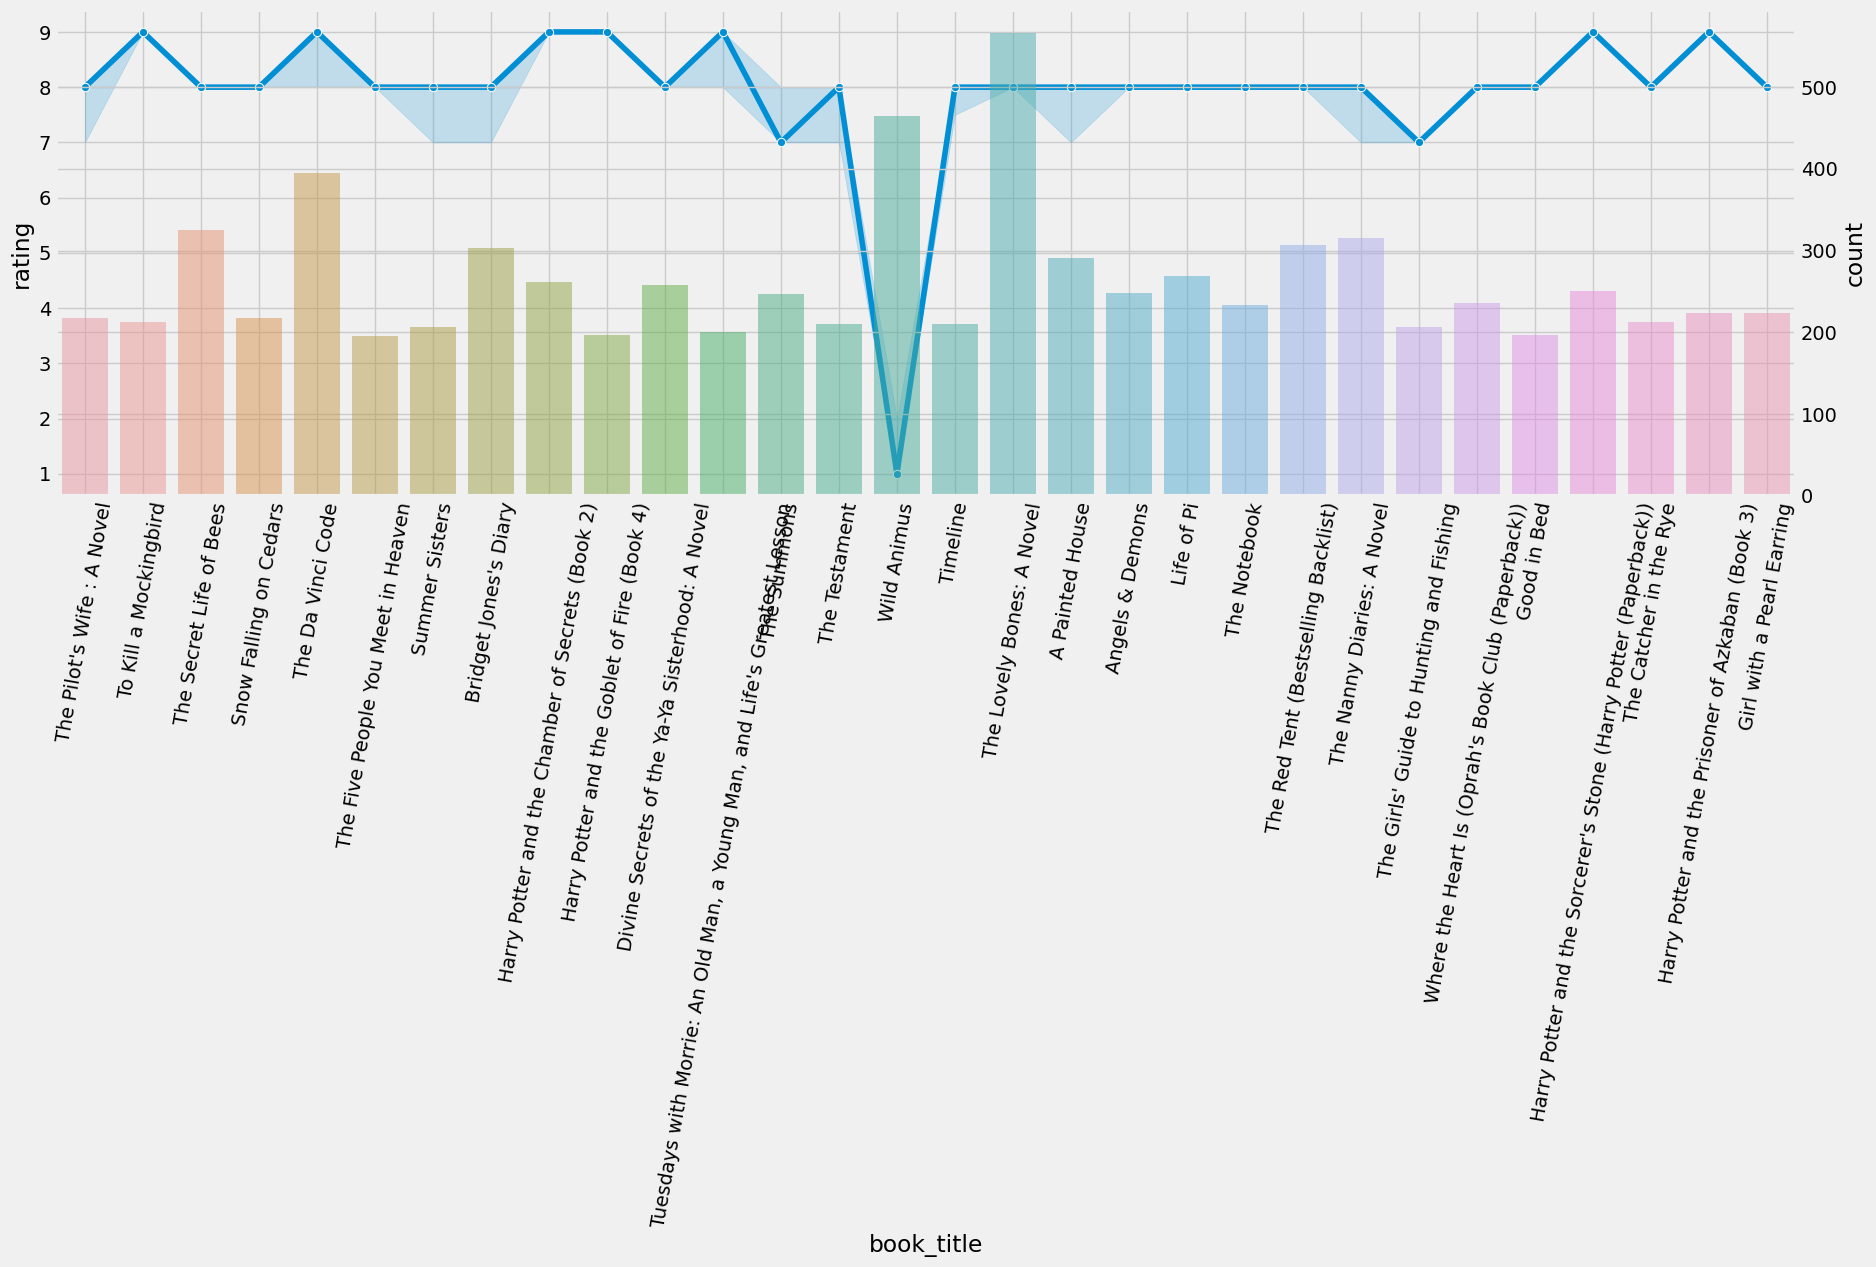

In [73]:
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

- isbn을 통해 popular book 추출

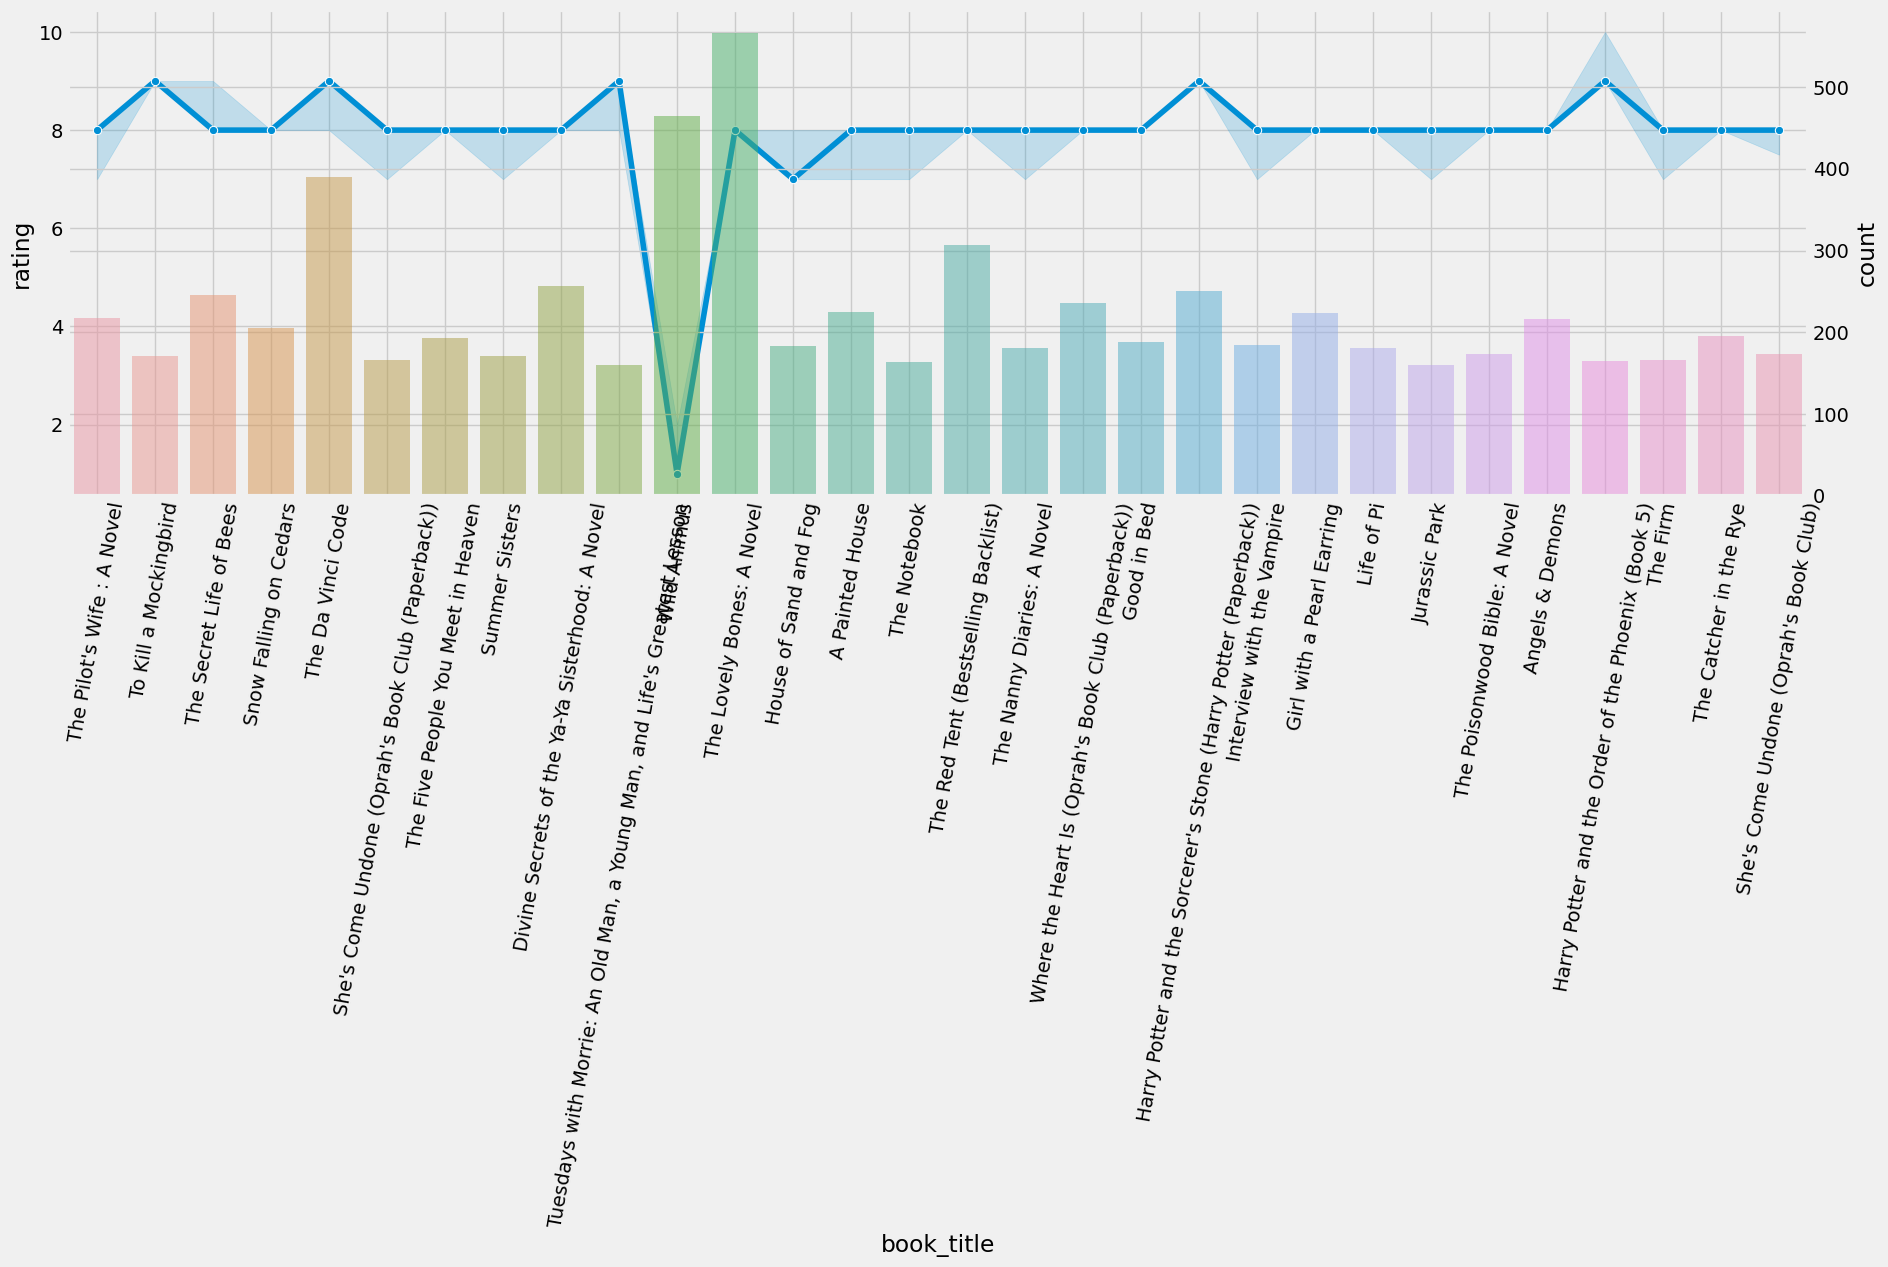

In [74]:
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

- 차이점 존재 : 특정 국가에서 인기 차이가 반영되기 때문 (?)
- 가장 많이 읽힌 책이 오히려 평점은 낮을 수 있음

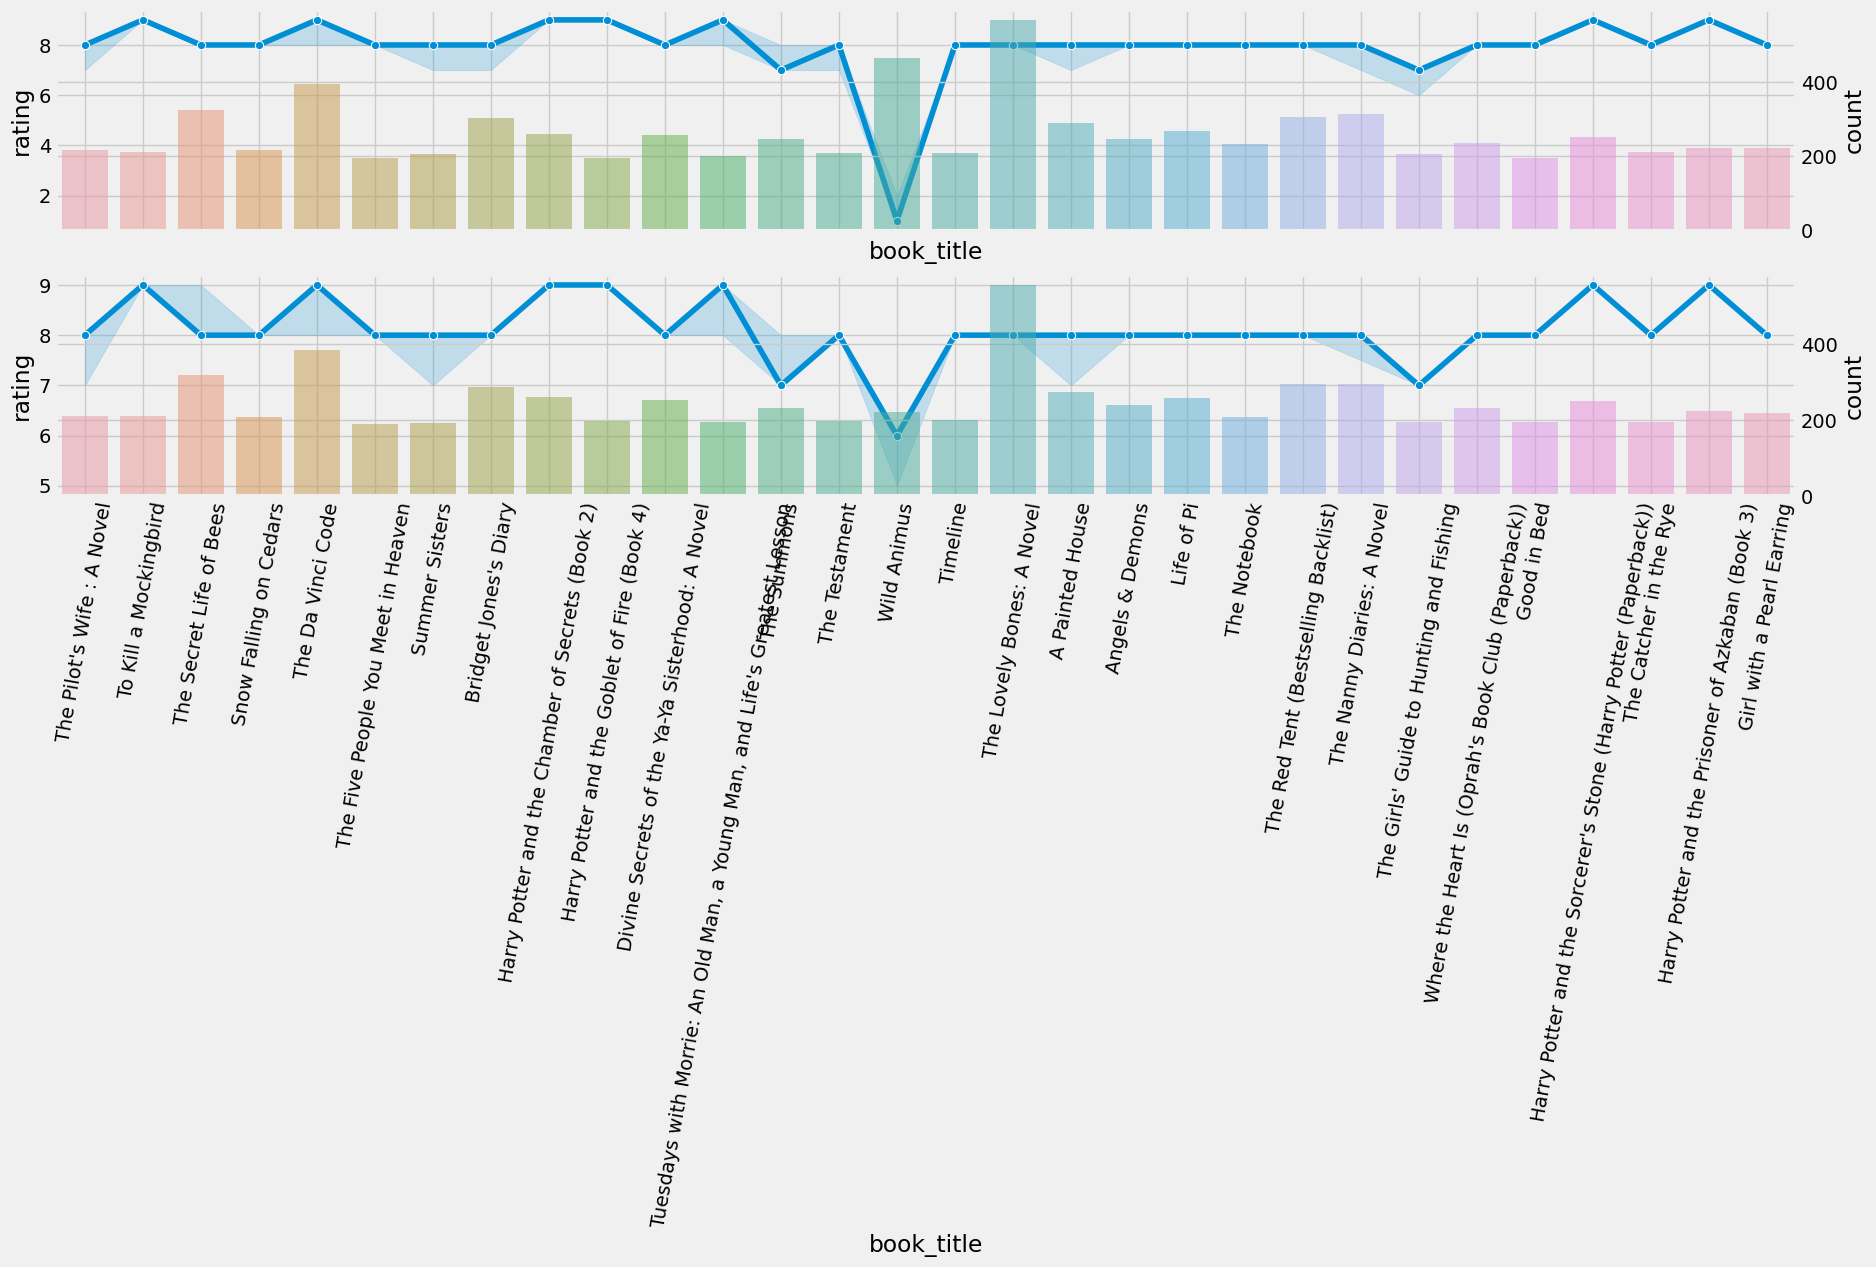

In [75]:
# book title을 사용했을떄
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

# ratings = 1인 경우 제외
plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()

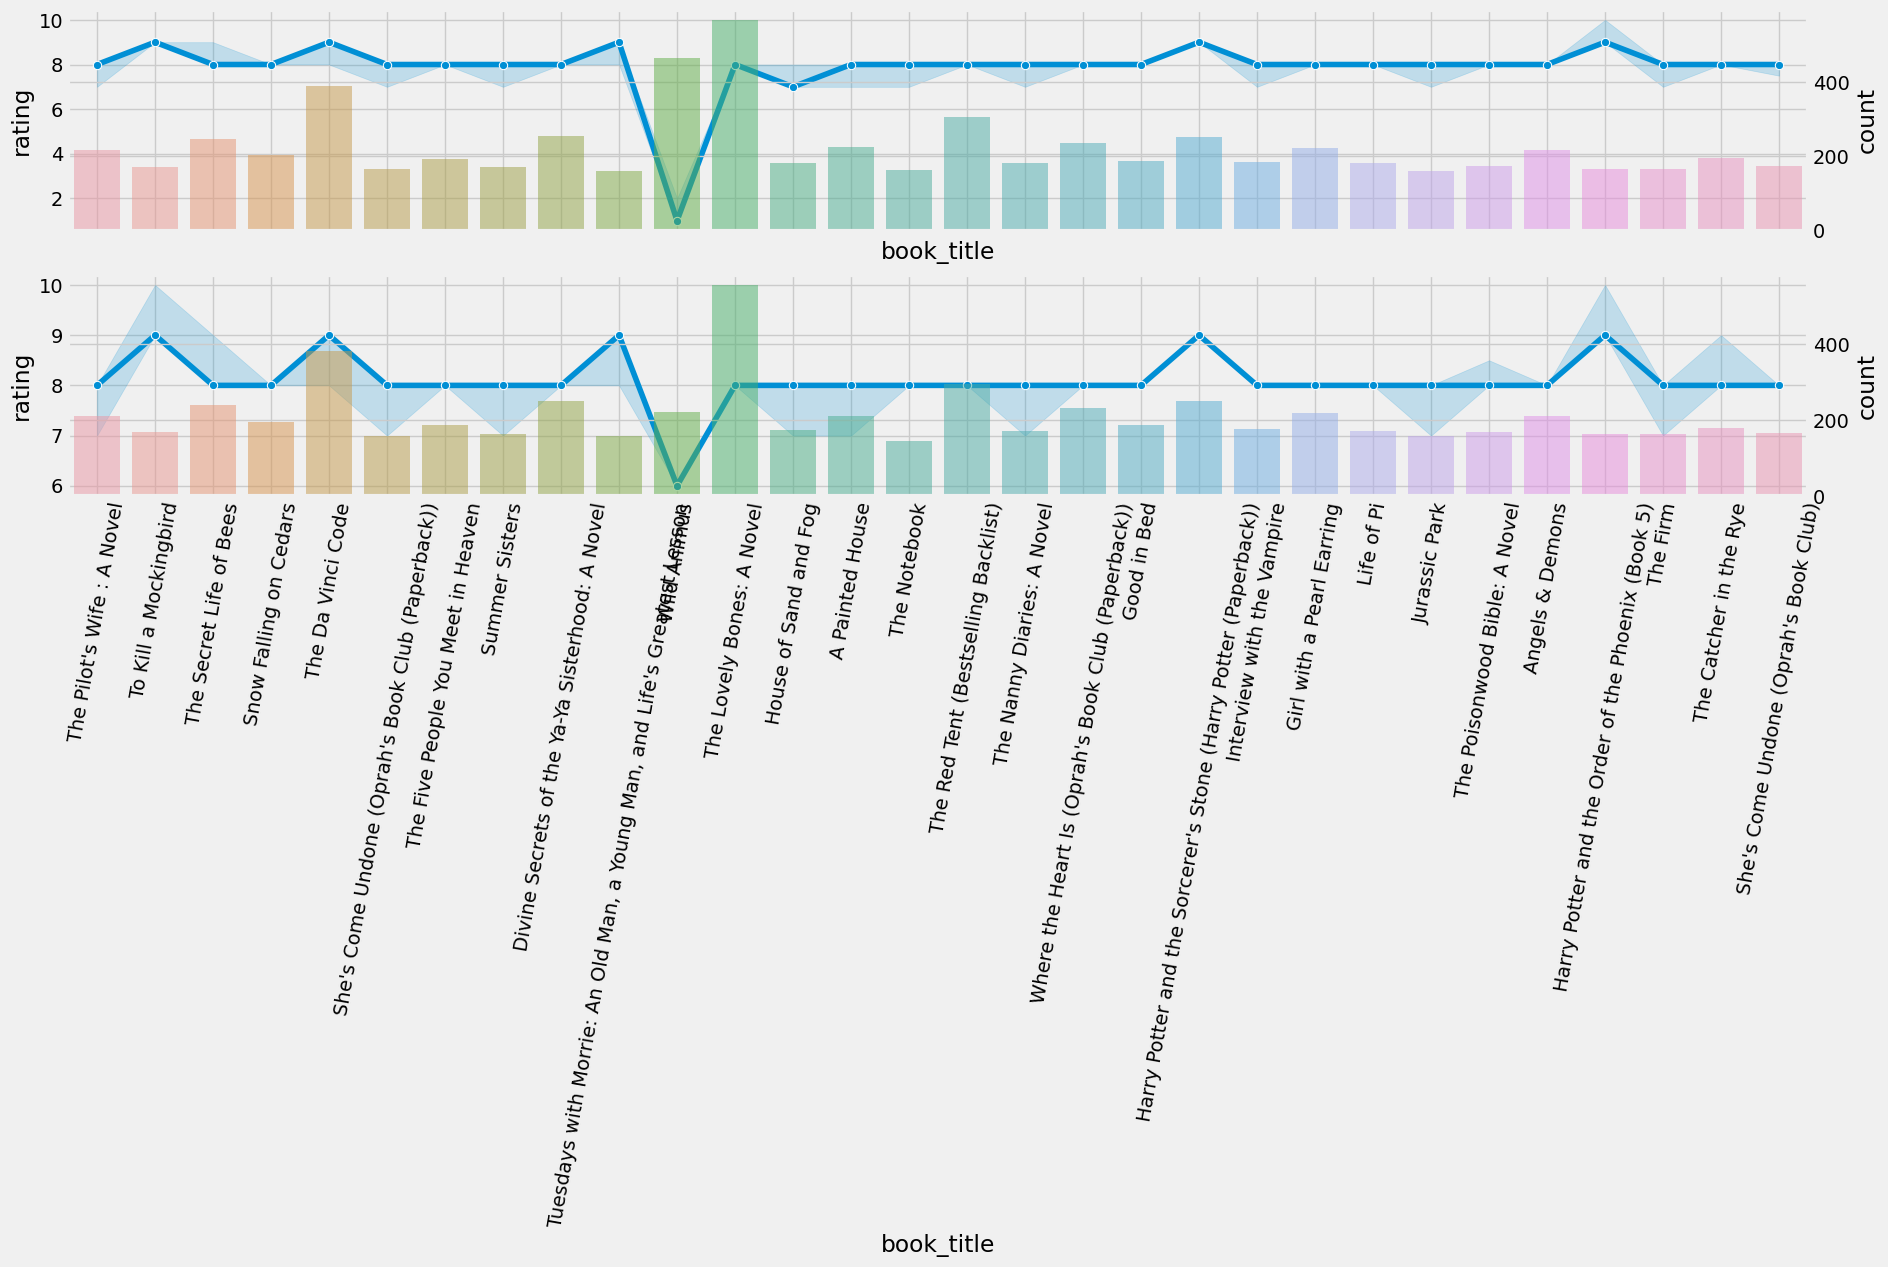

In [76]:
# isbn을 사용했을 때
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]
fig, ax1 = plt.subplots(2,1, figsize=(20,6))
plt.xticks(rotation=80)
plot1 = sns.lineplot(data=popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[0])
plot1 = sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax1[0].twinx())
plot1.set_xticklabels([])

# ratings = 1인 경우 제외
plot2 = sns.lineplot(data = popular_book[popular_book['rating']>1],x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1[1])
plot2 = sns.countplot(data=popular_book[popular_book['rating']>1], x='book_title', alpha=0.5, ax=ax1[1].twinx())
plt.show()


In [77]:
popular_cate_list = data['category'].value_counts().sort_values(ascending=False)[:10].index
popular_cate = data[data['category'].isin(popular_cate_list)]

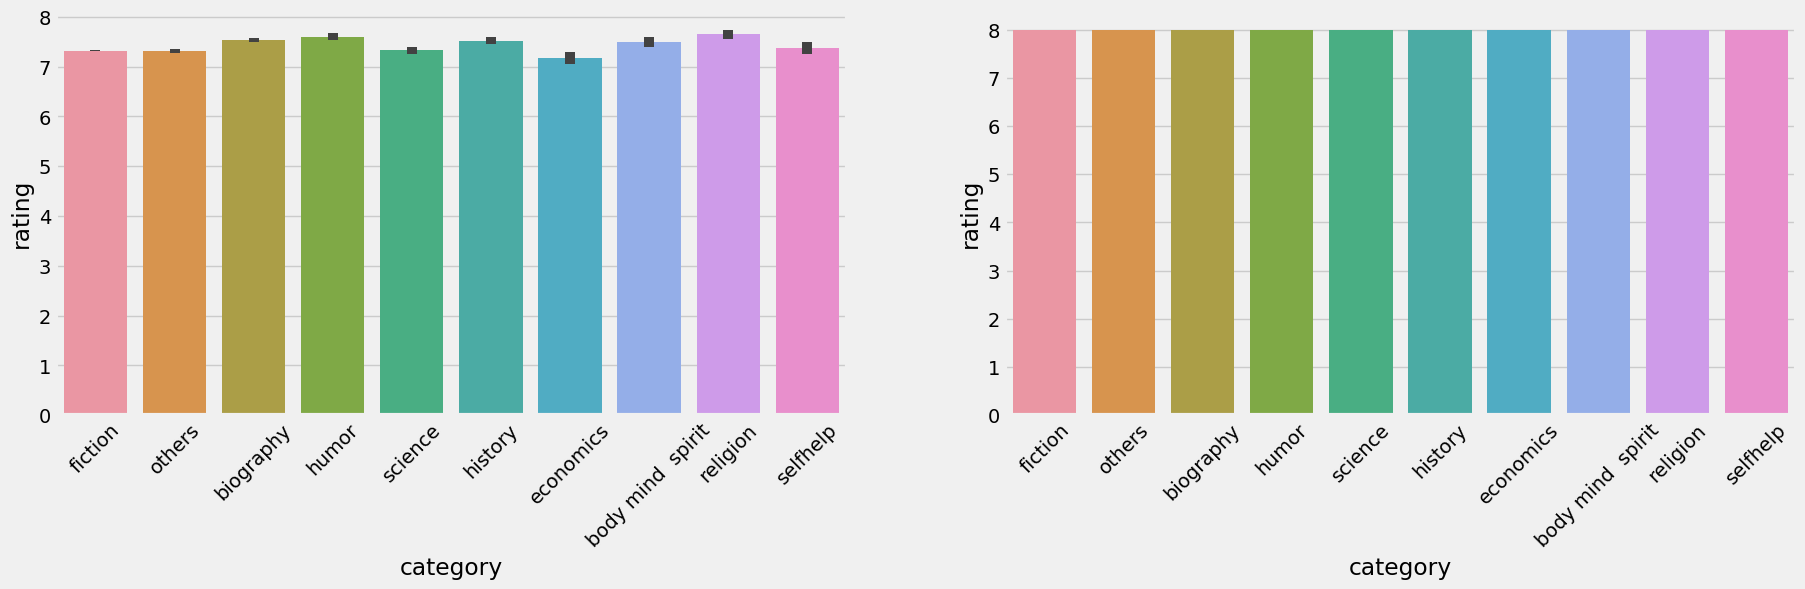

In [78]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot1 = sns.barplot(data=popular_cate[popular_cate['rating']>1], x='category', y='rating', estimator=np.mean, ax=ax[0], )
plot2 = sns.barplot(data=popular_cate[popular_cate['rating']>1], x='category', y='rating', estimator=np.median, ax=ax[1])
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)
plt.show()